<img width="400" src="https://nomeroff.net.ua/images/logo/nomeroff_net.svg" alt="Nomeroff Net. Automatic numberplate recognition system" align="left"/>

## The example demonstrates license plate number detection.

Before runing this demo, please download models from [https://nomeroff.net.ua/models/](https://nomeroff.net.ua/models/) to **./models/** directory. 

In [1]:
# Import all necessary libraries.
import os
import cv2
import numpy as np
import sys
import json
import matplotlib.image as mpimg
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# change this property
NOMEROFF_NET_DIR = os.path.abspath('../')

# specify the path to Mask_RCNN if you placed it outside Nomeroff-net project
MASK_RCNN_DIR = os.path.join(NOMEROFF_NET_DIR, 'Mask_RCNN')

MASK_RCNN_LOG_DIR = os.path.join(NOMEROFF_NET_DIR, 'logs')
MASK_RCNN_MODEL_PATH = os.path.join(NOMEROFF_NET_DIR, "models/mask_rcnn_numberplate_0700.h5")
OPTIONS_MODEL_PATH =  os.path.join(NOMEROFF_NET_DIR, "models/numberplate_options_2019_05_20.h5")

# If you use gpu version tensorflow please change model to gpu version named like *-gpu.pb
mode = "cpu"
OCR_NP_UKR_TEXT = os.path.join(NOMEROFF_NET_DIR, "models/anpr_ocr_ua_12-{}.h5".format(mode))
OCR_NP_EU_TEXT =  os.path.join(NOMEROFF_NET_DIR, "models/anpr_ocr_eu_2-{}.h5".format(mode))
OCR_NP_RU_TEXT =  os.path.join(NOMEROFF_NET_DIR, "models/anpr_ocr_ru_3-{}.h5".format(mode))
OCR_NP_KZ_TEXT =  os.path.join(NOMEROFF_NET_DIR, "models/anpr_ocr_kz_4-{}.h5".format(mode))

sys.path.append(NOMEROFF_NET_DIR)

Also you may use .pb models for options detectors or OCR detectors. 
More about conversion and preparing for inference withit https://github.com/ria-com/nomeroff-net/blob/master/examples/inference_convert.ipynb.

In [2]:
# Import license plate recognition tools.
from NomeroffNet import  filters, RectDetector, TextDetector, OptionsDetector, Detector, textPostprocessing, textPostprocessingAsync

# Initialize npdetector with default configuration file.
nnet = Detector(MASK_RCNN_DIR, MASK_RCNN_LOG_DIR)
nnet.loadModel(MASK_RCNN_MODEL_PATH)

rectDetector = RectDetector()

optionsDetector = OptionsDetector({
    "class_region": ["xx_unknown", "eu_ua_2015", "eu_ua_2004", "eu_ua_1995", "eu", "xx_transit", "ru", "kz"]
})
optionsDetector.load(OPTIONS_MODEL_PATH)

# Initialize text detector.
textDetector = TextDetector({
    "eu_ua_2004_2015": {
        "for_regions": ["eu_ua_2015", "eu_ua_2004"],
        "model_path": OCR_NP_UKR_TEXT
    },
    "eu": {
        "for_regions": ["eu", "eu_ua_1995"],
        "model_path": OCR_NP_EU_TEXT
    },
    "ru": {
        "for_regions": ["ru"],
        "model_path": OCR_NP_RU_TEXT
    },
    "kz": {
        "for_regions": ["kz"],
        "model_path": OCR_NP_KZ_TEXT
    }
})

Using TensorFlow backend.
W0604 18:22:51.649405 139788035814720 deprecation.py:237] From /usr/local/lib64/python3.6/site-packages/keras/backend/tensorflow_backend.py:4139: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0604 18:22:54.375291 139788035814720 deprecation.py:237] From /mnt/data/www/nomeroff-net/Mask_RCNN/mrcnn/model.py:341: The name tf.log is deprecated. Please use tf.math.log instead.

W0604 18:22:54.391513 139788035814720 deprecation.py:506] From /mnt/data/www/nomeroff-net/Mask_RCNN/mrcnn/model.py:423: calling crop_and_resize_v1 (from tensorflow.python.ops.image_ops_impl) with box_ind is deprecated and will be removed in a future version.
Instructions for updating:
box_ind is deprecated, use box_indices instead
W0604 18:22:54.659818 139788035814720 deprecation.py:237] From /mnt/data/www/nomeroff-net/Mask_RCNN/mrcnn/model.py:721: The name tf.sets.set_intersection is deprecated. Please use tf.sets.intersection instead.

W0604 18:22:54.6621

bad/39416711-39416711_2.jpg


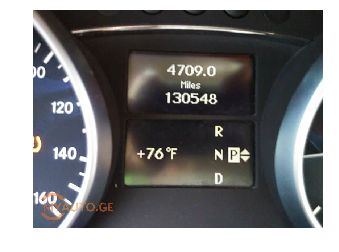

[[[571.86559519 375.        ]
  [573.08181141 420.        ]
  [538.         420.        ]
  [538.         375.        ]]]


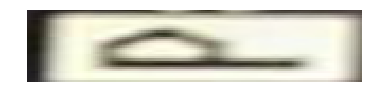

['xx_unknown']
[0]
['']
bad/182194773.jpeg


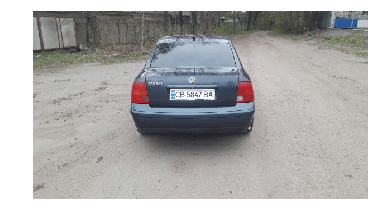

[[[244.         140.05245846]
  [326.         138.97351109]
  [326.         161.02648891]
  [244.         159.94754154]]]


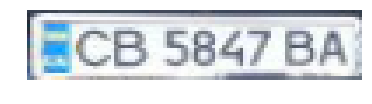

['eu_ua_2015']
[1]
['CB5847BA']
bad/203214359.jpeg


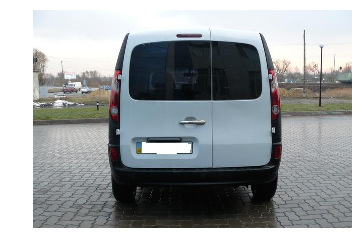

[[[319.         264.        ]
  [319.         290.00961451]
  [208.         288.95247165]
  [208.         264.        ]]]


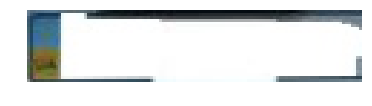

['eu_ua_2004']
[1]
['']
bad/210164671.jpeg


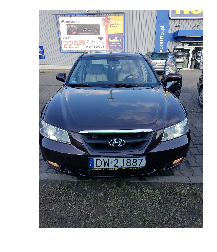

[[[521.         724.98387505]
  [521.         778.27664306]
  [247.14549249 783.60455177]
  [241.72671575 729.41678432]]

 [[345.         139.        ]
  [410.         139.        ]
  [410.         154.93249064]
  [345.         156.03418556]]

 [[-15.12272828 173.93931685]
  [ 19.81926663 171.75544217]
  [ 33.91576571 244.        ]
  [ -1.45235108 244.        ]]]


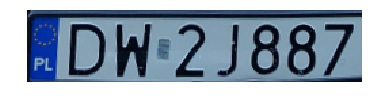

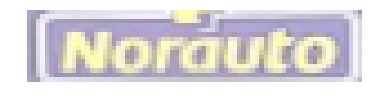

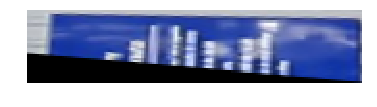

['eu', 'xx_unknown', 'xx_unknown']
[1, 0, 0]
['DW2J887', '', '']
bad/1652-main.jpg


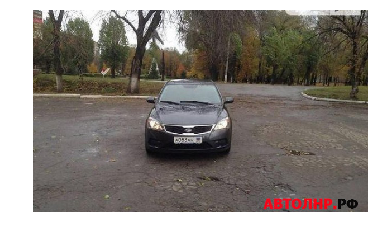

[[[304.         223.95789935]
  [304.         239.        ]
  [250.         239.        ]
  [250.         225.08289935]]]


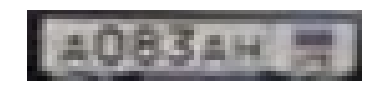

['ru']
[1]
['A063AY4']
bad/3812-main.jpg


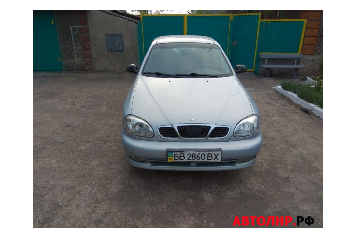

[[[279.         291.03874069]
  [388.         289.98048827]
  [388.         313.        ]
  [279.         313.        ]]]


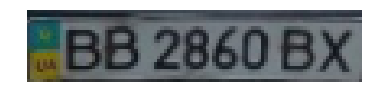

['eu_ua_2004']
[1]
['BB2860BX']
bad/212675111.jpeg


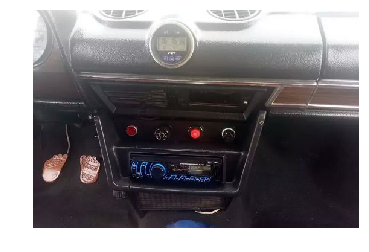

[[[204.  43.]
  [255.  43.]
  [255.  67.]
  [204.  67.]]]


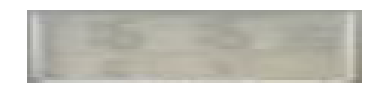

['xx_unknown']
[0]
['']
bad/2445-main.jpg


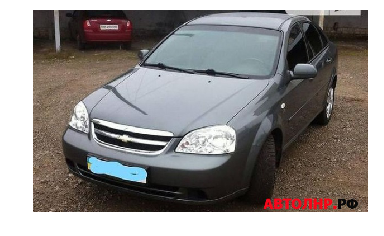

[[[118.          22.93222253]
  [154.          24.13222253]
  [154.          34.86777747]
  [118.          36.06777747]]]


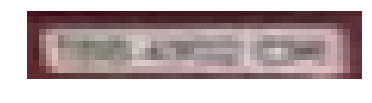

['xx_unknown']
[0]
['']
bad/202583502.jpeg


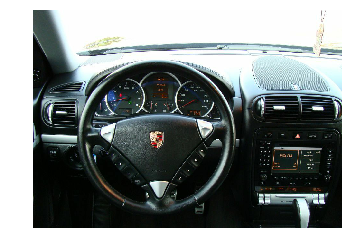

[[[106.         314.        ]
  [106.         325.07544535]
  [ 69.         323.70507498]
  [ 69.         314.        ]]]


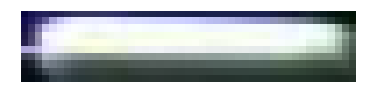

['xx_unknown']
[0]
['']
bad/39416217-39416217_8.jpg


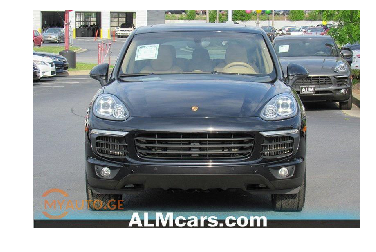

[[[253.49125814  84.        ]
  [308.9073506   84.        ]
  [305.13930813 117.91238226]
  [248.96123745 119.10766036]]

 [[652.         184.        ]
  [692.         184.        ]
  [692.         203.34971555]
  [652.         205.08884599]]]


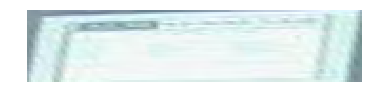

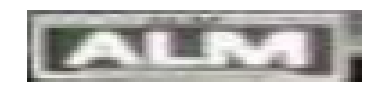

['xx_unknown', 'xx_unknown']
[0, 0]
['', '']
bad/201534852.jpeg


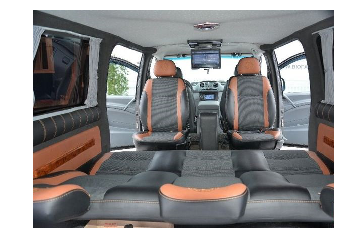

[[[363.         165.        ]
  [363.         177.78086182]
  [339.         179.11419515]
  [339.         165.        ]]]


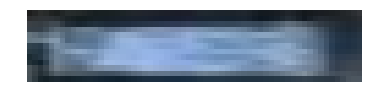

['xx_unknown']
[0]
['']
bad/234428247.jpeg


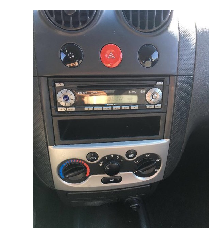

[[[ 98. 284.]
  [ 98. 297.]
  [ 70. 297.]
  [ 70. 284.]]]


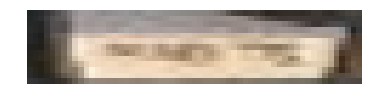

['xx_unknown']
[0]
['']
bad/202245536.png


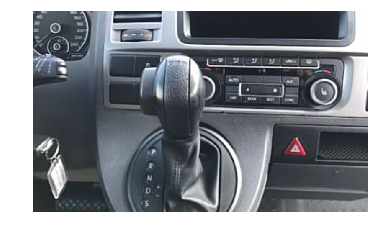

[]
[]
[]
[]
bad/36590936-36590936_7.jpg


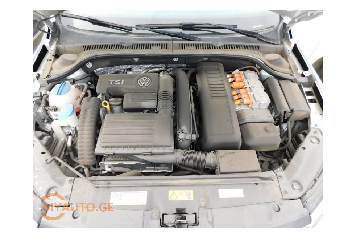

[[[371.         494.        ]
  [443.         494.        ]
  [443.         523.88148788]
  [371.         526.03074161]]]


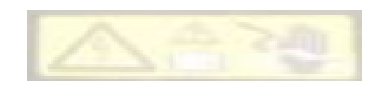

['xx_unknown']
[0]
['']
bad/241847206.jpeg


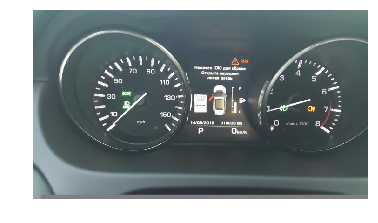

[[[344.         175.87239696]
  [374.         177.12239696]
  [374.         218.8868335 ]
  [344.         220.04067965]]]


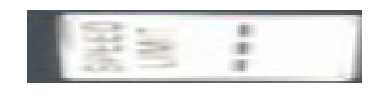

['xx_unknown']
[0]
['']
bad/39273821-39273821_6.jpg


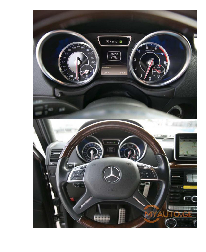

[[[380.70063942 817.        ]
  [384.79760912 884.6       ]
  [350.         884.6       ]
  [350.         817.        ]]

 [[318.82894433 230.        ]
  [322.49561099 241.        ]
  [285.50438901 241.        ]
  [281.83772234 230.        ]]]


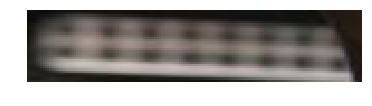

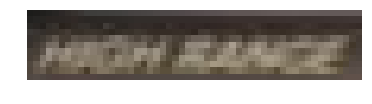

['xx_unknown', 'xx_unknown']
[0, 0]
['', '']
bad/233523221.jpeg


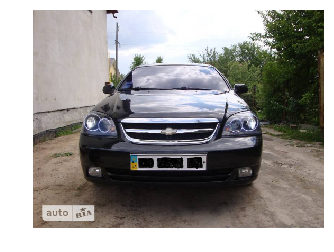

[[[330.         272.07173543]
  [330.         301.        ]
  [184.         301.        ]
  [184.         269.971016  ]]

 [[116.18155915 365.07384539]
  [114.78127982 395.87999065]
  [ 19.         397.87543398]
  [ 19.         368.46389978]]]


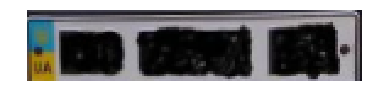

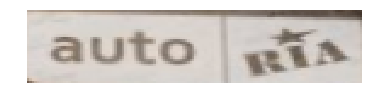

['eu_ua_2004', 'xx_unknown']
[1, 0]
['AB', '']
bad/183635594.jpeg


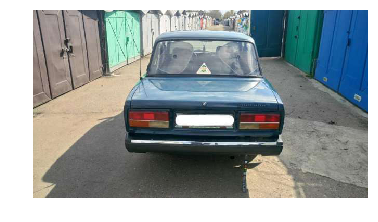

[[[384.         199.        ]
  [384.         220.96125931]
  [275.         222.01951173]
  [275.         199.        ]]]


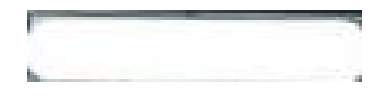

['xx_unknown']
[0]
['']
bad/39399504-39399504_1.jpg


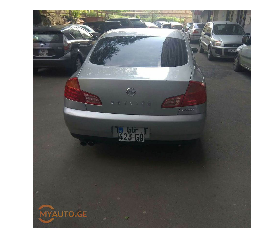

[[[804.38503731 161.        ]
  [837.         161.        ]
  [837.         174.63510909]
  [802.76795571 177.17081608]]

 [[ 61.93193957 160.        ]
  [ 64.25462463 190.19490573]
  [ 19.97936051 187.59047843]
  [ 18.7797745  160.        ]]]


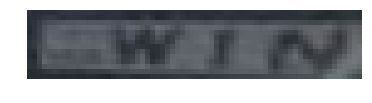

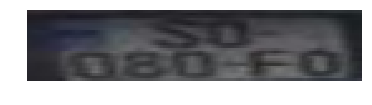

['xx_unknown', 'kz']
[0, 2]
['', 'BPE6']
bad/202501063.jpeg


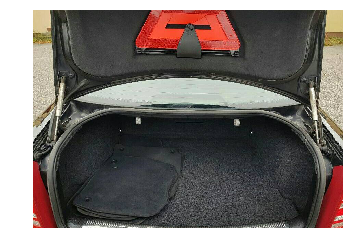

[]
[]
[]
[]
bad/233997913.jpeg


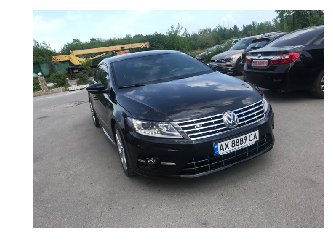

[[[537.         282.038189  ]
  [537.         309.25349816]
  [426.         347.52936023]
  [426.         316.95953731]]

 [[519.         117.        ]
  [559.         117.        ]
  [559.         134.06777747]
  [519.         132.73444414]]]


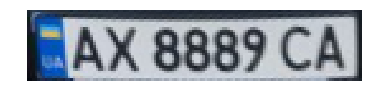

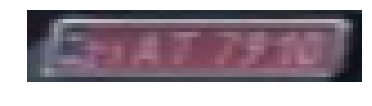

['eu_ua_2015', 'xx_transit']
[1, 1]
['AX8889CA', '']


In [3]:
# Walking through the ./examples/images/ directory and checking each of the images for license plates.
rootDir = 'bad/'

max_img_w = 1600
for dirName, subdirList, fileList in os.walk(rootDir):
    for fname in fileList:
        img_path = os.path.join(dirName, fname)
        print(img_path)
        img = mpimg.imread(img_path)
        plt.axis("off")
        plt.imshow(img)
        plt.show()
         
        # corect size for better speed
        img_w = img.shape[1]
        img_h = img.shape[0]
        img_w_r = 1
        img_h_r = 1
        if img_w > max_img_w:
            resized_img = cv2.resize(img, (max_img_w, int(max_img_w/img_w*img_h)))
            img_w_r = img_w/max_img_w
            img_h_r = img_h/(max_img_w/img_w*img_h)
        else:
            resized_img = img

        NP = nnet.detect([resized_img]) 
        
        # Generate image mask.
        cv_img_masks = await filters.cv_img_mask_async(NP)
            
        # Detect points.
        arrPoints = await rectDetector.detectAsync(cv_img_masks, outboundHeightOffset=3-img_w_r, fixGeometry=True, fixRectangleAngle=10)
        print(arrPoints)
        arrPoints[..., 1:2] = arrPoints[..., 1:2]*img_h_r
        arrPoints[..., 0:1] = arrPoints[..., 0:1]*img_w_r
        
        # cut zones
        zones = await rectDetector.get_cv_zonesBGR_async(img, arrPoints)
        toShowZones = await rectDetector.get_cv_zonesRGB_async(img, arrPoints)
        for zone, points in zip(toShowZones, arrPoints):
            plt.axis("off")
            plt.imshow(zone)
            plt.show()
    
        # find standart
        regionIds, stateIds, countLines = optionsDetector.predict(zones)
        regionNames = optionsDetector.getRegionLabels(regionIds)
        print(regionNames)
        print(countLines)

        # find text with postprocessing by standart  
        textArr = textDetector.predict(zones, regionNames, countLines)
        textArr = await textPostprocessingAsync(textArr, regionNames)
        print(textArr)